<a href="https://colab.research.google.com/github/sankalpachowdhury/Fractal_Analysis/blob/master/Higuchi_Fractal_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#C codes

In [ ]:
#include <stdio.h>

int main()
{
   int i, j, k, m, n, s=0, l, x=0;
   printf("Enter sample size:");
   scanf("%d",&n);
   printf("Enter largest time delay parameter:");
   scanf("%d",&k);
   int a[n];
   for(i=2;i<=k;i++)
   {
       for(m=0;m<i;m++)
       {
            for(j=m;j<n;j=j+i)
                s=s+a[j+i]-a[j];
            l=(s*(n-1))/(j*i);
            s=0;
            x=x+l;
       }
       printf("The average is %d for k= %d",x/i,i);
       x=0;
   }
}

In [ ]:
#include <stdio.h>

int main()
{
      int n, k, i=0, b=0, s=0, l=0, m;
    printf("Enter sample size:");
    scanf("%d",&n);
    printf("\nEnter the time delay parameter:");
    scanf("%d",&b);
    int a[n];
    while(i<n)
        {
            scanf("%d",&a[i]);
            i++;
        }
    for(k=2;k<=b;k++)
    {
        for(m=0;m<k;m++)
        {
            for(i=m;i<n;i=i+k)
                s=s+a[i+k]-a[i];
            l=l+((s*(n-1))/((i+k)*k));
            s=0;
        }
        printf("\nAvg length %d for %d",l/k,k);
        l=0;
    }

}

In [ ]:
#!git clone https://github.com/inuritdino/HiguchiFractalDimension.git

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
import os
import ctypes
import numpy as np
from numpy.ctypeslib import ndpointer

def curve_length(X,opt=False,num_k=50,k_max=None):
    """
    Calculate curve length <Lk> for Higuchi Fractal Dimension (HFD)
    
    Input:
    
    X - input (time) series (must be 1D, to be converted into a NumPy array)
    opt (=True) - optimized? (if libhfd.so was compiled uses the faster code).
    num_k - number of k values to generate.
    k_max - the maximum k (the k array is generated uniformly in log space 
            from 2 to k_max)
    Output:
    k - interval "times", window sizes
    Lk - curve length
    """
    ### Make sure X is a NumPy array with the correct dimension
    X = np.array(X)
    if X.ndim != 1:
        raise ValueError("Input array must be 1D (time series).")
    N = X.size

    ### Get interval "time"
    k_arr = interval_t(N,num_val=num_k,kmax=k_max)

    ### The average length
    Lk = np.empty(k_arr.size,dtype=np.float)

    ### C library
    '''
    if opt:
        X = np.require(X, float, ('C', 'A'))
        k_arr = np.require(k_arr, ctypes.c_size_t, ('C', 'A'))
        Lk = np.require(Lk, float, ('C', 'A'))
        ## Load library here
        libhfd = init_lib()
        ## Run the C code here
        libhfd.curve_length(k_arr,k_arr.size,X,N,Lk)
    '''
    #else:
        ### Native Python run
    for i in range(k_arr.size):# over array of k's
            Lmk = 0.0
            for j in range(k_arr[i]):# over m's
                ## Construct X_k^m, i.e. X_(k_arr[i])^j, as X[j::k_arr[i]]
                ## Calculate L_m(k)
                Lmk += (
                    np.sum(
                        np.abs(
                            np.diff( X[j::k_arr[i]] )
                        )
                    )
                    * (N - 1) /
                    (
                        ( (N-j-1)//k_arr[i] )
                        *
                        k_arr[i]
                    )
                ) / k_arr[i]

            ### Calculate the average Lmk
            Lk[i] = Lmk / k_arr[i]

    return (k_arr, Lk);

def lin_fit_hfd(k,L,log=True):
    """
    Calculate Higuchi Fractal Dimension (HFD) by fitting a line to already computed
    interval times k and curve lengths L
    Input:
    k - interval "times", window sizes
    L - curve length
    log (=True) - k and L values will be transformed to np.log2(k) and np.log2(L),
                  respectively
    Output:
    HFD
    """
    if log:
        return (-np.polyfit(np.log2(k),np.log2(L),deg=1)[0]);
    else:
        return (-np.polyfit(k,L,deg=1)[0]);

def hfd(X,**kwargs):
    """
    Calculate Higuchi Fractal Dimension (HFD) for 1D data/series
    Input:
    X - input (time) series (must be 1D, to be converted into a NumPy array)
    Output:
    
    HFD
    """
    k, L = curve_length(X,**kwargs)
    return lin_fit_hfd(k, L);

# Generating th interval
def interval_t(size,num_val=50,kmax=None):
    ### Generate sequence of interval times, k
    if kmax is None:
        k_stop = size//2
    else:
        k_stop = kmax
    if k_stop > size//2:   ## prohibit going larger than N/2
        k_stop = size//2
        print("Warning: k cannot be longer than N/2")
        
    k = np.logspace(start=np.log2(2),stop=np.log2(k_stop),base=2,num=num_val,dtype=np.int)
    return np.unique(k);

def init_lib():
    libdir = os.path.dirname(__file__)
    libfile = os.path.join(libdir, "libhfd.so")
    lib = ctypes.CDLL(libfile)

    rwptr = ndpointer(float, flags=('C','A','W'))
    rwptr_sizet = ndpointer(ctypes.c_size_t, flags=('C','A','W'))

    lib.curve_length.restype = ctypes.c_int
    lib.curve_length.argtypes = [rwptr_sizet, ctypes.c_size_t, rwptr, ctypes.c_size_t, rwptr]

    return lib;

In [5]:
x = np.random.randn(10000)
y = np.empty(9900)
for i in range(x.size-100):
	y[i] = np.sum(x[:(i+100)])
	
## Note x is a Guassian noise, y is the original Brownian data used in Higuchi, Physica D, 1988.

print(hfd(x)) # ~ 2.00
print(hfd(y)) # ~ 1.50
#print(a, b)

1.9995150710886302
1.5031246935230607


#Data Preprocessing

In [6]:
data = pd.read_csv('/content/DATA.csv')
data.head()

,DATE,SNO.,MAHARASHTRA,ANDHRA PRADESH,TAMIL NADU,KARNATAKA,UTTAR PRADESH,DELHI,WEST BENGAL,GUJARAT,KERALA,UTTARAKHAND
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/04/2020,1.0,33.0,67.0,110.0,9.0,13.0,32.0,37.0,13.0,24.0,7.0
2,02/04/2020,2.0,88.0,38.0,75.0,14.0,11.0,141.0,16.0,1.0,21.0,3.0
3,03/04/2020,3.0,64.0,15.0,102.0,4.0,46.0,93.0,0.0,7.0,9.0,6.0
4,04/04/2020,4.0,148.0,28.0,74.0,16.0,60.0,59.0,0.0,13.0,11.0,6.0


In [7]:
maha = data.MAHARASHTRA
print(maha[1:154])

1         33.0
2         88.0
3         64.0
4        148.0
5        112.0
        ...   
149    14857.0
150    14427.0
151    16286.0
152    16408.0
153    11852.0
Name: MAHARASHTRA, Length: 153, dtype: float64


In [8]:
import pandas
print(pandas.__version__)

1.0.5


In [9]:
# convert dataframe to np.array
import numpy
maha_np_array = data['MAHARASHTRA'].to_numpy()
#maha_np_array = list(numpy.concatenate().flat)) 
print(maha_np_array[1:154])


[   33.    88.    64.   148.   112.   121.   150.   117.   229.   210.
   187.   221.   352.   346.   236.   285.   120.   327.   552.   466.
   552.   431.   778.   390.   811.   440.   522.   728.   597.   583.
  1008.   790.   678.  1567.   984.  1233.  1216.  1089.  1165.  1943.
  1230.  1026.  1495.  1602.  1576.  1606.  2347.  2005.  2078.  2161.
  2345.  2940.  2608.  3041.  2436.  2091.  2190.  2598.  2682.  2940.
  2487.  2358.  2287.  2560.  2933.  2436.  2739.  3007.  2554.  2258.
  3254.  3607.  3493.  3427.  3390.  2786.  2701.  3307.  3752.  3827.
  3874.  3870.  3721.  3214.  3889.  4842.  5024.  6368.  5493.  5257.
  4878.  5537.  6328.  6364.  7074.  6555.  5368.  5134.  6603.  6875.
  7862.  8139.  7827.  4697.  6741.  7975.  8641.  8308.  8348.  9518.
  8240.  8336. 10576.  9895.  9615.  9251.  9431.  7924.  7717.  9211.
 11147. 10320.  9601.  9509.  8968.  7760. 10309. 11514. 10483. 12822.
 12248.  9181. 11088. 12712. 11813. 12608. 12020. 11111.  8493. 11119.
 13165

In [10]:
# inputs to Higuchi Algorithm

# k_value = int(input("Enter the bound og 'k' "))
data_list = maha_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [33116.56333333 16414.08592593  9743.01182432  3578.24302469
  2298.47569444  1909.99001905  1090.81049563   836.62225652
   616.07096836   452.75679525   342.09224345   258.47501795
   196.05613037]


In [11]:
hfd(data_list)

1.3152317436347447

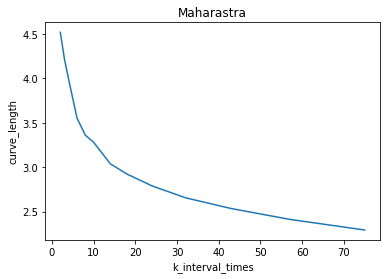

In [20]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Maharastra") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()